# Import Data

In [595]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import holidays
import statsmodels.api as sm

In [596]:
collisions = pd.read_csv(os.path.join('traffic','pd_collisions_datasd.csv'))
traffic = pd.read_csv(os.path.join('traffic','traffic_counts_datasd.csv'))

In [597]:
traffic

,id,street_name,limits,all_count,northbound_count,southbound_count,eastbound_count,westbound_count,total_count,file_no,count_date
0,01AV018207,01 AV,A ST - ASH ST,,18010,NaN,NaN,NaN,18010,0182-07,2007-03-13 00:00:00
1,01AV015210,01 AV,A ST - ASH ST,,20060,NaN,NaN,NaN,20060,0152-10,2010-03-18 00:00:00
2,01AV018213,01 AV,A ST - ASH ST,,19597,NaN,NaN,NaN,19597,0182-13,2013-03-12 00:00:00
3,01AV088812,01 AV,ASH ST - BEECH ST,,2298,NaN,NaN,NaN,2298,0888-12,2012-12-11 00:00:00
4,01AV068711,01 AV,B ST - A ST,,15625,NaN,NaN,NaN,15625,0687-11,2011-09-01 00:00:00
5,01AV000714,01 AV,B ST - A ST,,13569,NaN,NaN,NaN,13569,0007-14,2014-02-11 00:00:00
6,01AV048412,01 AV,B ST - C ST,,13389,NaN,NaN,NaN,13389,0484-12,2012-05-31 00:00:00
7,01AV048115,01 AV,B ST - C ST,,13995,NaN,NaN,NaN,13995,0481-15,2015-06-17 00:00:00
8,01AV019406,01 AV,BEECH ST - CEDAR ST,,27450,NaN,NaN,NaN,27450,0194-06,2006-03-23 00:00:00
9,01AV017909,01 AV,BEECH ST - CEDAR ST,,22345,NaN,NaN,NaN,22345,0179-09,2009-03-31 00:00:00


In [598]:
# Time processing
traffic['count_date'] = traffic['count_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
collisions['date_time'] = collisions['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
collisions['date'] = collisions['date_time'].apply(lambda x: x.date())
collisions['time'] = collisions['date_time'].apply(lambda x: x.time())
collisions['hour'] = collisions['time'].map(lambda t: t.hour)
collisions['DayOfWeek'] = collisions['date'].apply(lambda x:datetime.combine(x, datetime.min.time()).weekday())
us_holidays = holidays.UnitedStates()
collisions['holiday'] = collisions['date'].apply(lambda x: us_holidays.get(x))
traffic['DayOfWeek'] = traffic['count_date'].apply(lambda x:datetime.combine(x, datetime.min.time()).weekday())
traffic['holiday'] = traffic['count_date'].apply(lambda x: us_holidays.get(x))
collisions['is_holiday'] = collisions['holiday'].notnull()
collisions['is_weekend'] = collisions['DayOfWeek'] >= 5
traffic['is_holiday'] = traffic['holiday'].notnull()
traffic['is_weekend'] = traffic['DayOfWeek'] >= 5
collisions['has_injuries'] = collisions['injured'] != 0
collisions['has_deaths'] = collisions['killed'] != 0

# Data Cleaning

In [599]:
# Detect invalid police_beat
error = collisions[collisions['police_beat']<=100]
for i in error.index:
    collisions['police_beat'][i] = collisions[collisions['street_name'] == error['street_name'][i]].iloc[-1]['police_beat']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Data Analysis

## Exploratary Numerical Data Analysis

In [600]:
collisions[['injured','killed']].describe().T

,count,mean,std,min,25%,50%,75%,max
injured,22708.0,0.598468,1.646540,0.0,0.0,0.0,1.0,180.0
killed,22708.0,0.005064,0.074022,0.0,0.0,0.0,0.0,3.0


In [601]:
a = round(len(collisions[collisions['killed'] != 0])/len(collisions)*100,2)
b = round(len(collisions[collisions['injured'] != 0])/len(collisions)*100,3)
print("Given a collision happens, there are {}% chance that the collision causes injuries, and {}% chance that the collision causes death.".format(a,b))

Given a collision happens, there are 0.49% chance that the collision causes injuries, and 44.302% chance that the collision causes death.


In [602]:
collisions[collisions['injured'] == max(collisions['injured'])]

,report_id,date_time,police_beat,street_no,street_dir,street_name,street_type,cross_st_dir,cross_st_name,cross_st_type,...,hit_run_lvl,date,time,hour,DayOfWeek,holiday,is_holiday,is_weekend,has_injuries,has_deaths
9835,180304,2017-12-15 20:22:00,441,0,,OCEAN VIEW,BOULEVARD,,MILBRAE,STREET,...,NaN,2017-12-15,20:22:00,20,4,None,False,False,True,False


In [603]:
collisions[collisions['killed'] == max(collisions['killed'])]

,report_id,date_time,police_beat,street_no,street_dir,street_name,street_type,cross_st_dir,cross_st_name,cross_st_type,...,hit_run_lvl,date,time,hour,DayOfWeek,holiday,is_holiday,is_weekend,has_injuries,has_deaths
19838,189858,2018-12-20 13:37:00,246,11300,,VILLAGE RIDGE,ROAD,,,,...,NaN,2018-12-20,13:37:00,13,3,None,False,False,False,True


The highest number of injuries involves 180 injuries, which is happened in December 15th 2017 Ocean view Boulevard crossed at MilBrae street, by the violation of YIELD RIGHT OF WAY TO PEDESTRIANS.
The highest number of deaths involves 3 deaths, which is happened in December 20th 2018 Village Ridge Road, by the violation of TURNING MOVEMENTS AND REQUIRED SIGNALS.

In [604]:
collisions.groupby('charge_desc').agg(sum)[['injured','killed']].sort_values(by = 'killed', ascending = False).head(10)

,injured,killed
charge_desc,,
PEDESTRIANS OUTSIDE CROSSWALKS,140,18
TURNING MOVEMENTS AND REQUIRED SIGNALS,2319,18
MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHICLE CODE,1072,13
VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR CONDITIONS,2285,12
YIELD RIGHT OF WAY TO PEDESTRIANS,657,9
RED OR STOPVEHICLES STOP AT LIMIT LINE,1697,8
LEFT TURN YIELD UNTIL SAFE OR U-TURN,838,6
SIGNAL LIGHTS:CIRCULAR RED (I),64,4
PEDESTRIAN NOT TO SUDDENLY ENTER PATH ETC,132,3


In [605]:
collisions.groupby('charge_desc').agg(sum)[['injured','killed']].sort_values(by = 'injured', ascending = False).head(10)

,injured,killed
charge_desc,,
TURNING MOVEMENTS AND REQUIRED SIGNALS,2319,18
VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR CONDITIONS,2285,12
RED OR STOPVEHICLES STOP AT LIMIT LINE,1697,8
MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHICLE CODE,1072,13
LEFT TURN YIELD UNTIL SAFE OR U-TURN,838,6
FOLLOWING TOO CLOSELY,817,0
YIELD RIGHT OF WAY TO PEDESTRIANS,657,9
ENTERING HWY FROM PRIVATE ROAD OR DRIVEWAY,510,1
ENTRANCE FROM STOP THROUGH HIGHWAYYIELD UNTIL REASONABLY SAFE,483,0


In [606]:
collisions.groupby('hour').agg(sum)[['injured','killed']].sort_values(by = 'killed', ascending = False).head(5)

,injured,killed
hour,,
18,950,12
19,641,9
13,791,9
23,318,7
7,659,7


In [607]:
collisions.groupby('hour').agg(sum)[['injured','killed']].sort_values(by = 'injured', ascending = False).head(5)

,injured,killed
hour,,
17,1119,6
14,1043,5
15,977,3
18,950,12
16,919,5


In [608]:
collisions.groupby('street_type').mean().head()[['injured','killed']]

,injured,killed
street_type,,
,0.640414,0.007955
AVENUE,0.595272,0.004477
BOULEVARD,0.731187,0.007236
CIRCLE,0.428571,0.000000
COURT,0.239521,0.000000


In [609]:
collisions.groupby('violation_type').mean().head()[['injured','killed']]

,injured,killed
violation_type,,
CO,1.000000,0.000000
HS,0.500000,0.000000
MC,0.909091,0.000000
PC,0.333333,0.000000
VC,0.598412,0.005028


## Question: How does total_counts of cars related to injuries/ deaths?

In [610]:
collisions_tmp = pd.read_csv(os.path.join('traffic','pd_collisions_datasd.csv'))
traffic_tmp = pd.read_csv(os.path.join('traffic','traffic_counts_datasd.csv'))
error = collisions[collisions['police_beat']<=100]
for i in error.index:
    collisions['police_beat'][i] = collisions[collisions['street_name'] == error['street_name'][i]].iloc[-1]['police_beat']
traffic_tmp['year'] = traffic_tmp['count_date'].apply(lambda x: x.split('-')[0])
lst = traffic_tmp['year'].apply(lambda x: (int(x)>= 2017) & (int(x) <= 2019))
traffic_tmp = traffic_tmp[lst]
traffic_tmp['street_name_clean'] = traffic_tmp['street_name'].apply(lambda x: ' '.join(x.split(' ')[:-1]))
collisions_tmp['date'] = collisions_tmp['date_time'].apply(lambda x: x.split(' ')[0])
traffic_tmp['date'] = traffic_tmp['count_date'].apply(lambda x: x.split(' ')[0])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [611]:
total = pd.merge(collisions_tmp, traffic_tmp, left_on = ['street_name', 'date'], right_on = ['street_name_clean','date'])
total['date'] = total['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
#collisions['date'] = collisions['date_time'].apply(lambda x: x.date())
total['DayOfWeek'] = total['date'].apply(lambda x:datetime.combine(x, datetime.min.time()).weekday())
total['holiday'] = total['count_date'].apply(lambda x: us_holidays.get(x))
total['is_holiday'] = total['holiday'].notnull()
total['is_weekend'] = total['DayOfWeek'] >= 5
total['has_injuries'] = total['injured'] != 0
total['has_deaths'] = total['killed'] != 0
total

,report_id,date_time,police_beat,street_no,street_dir,street_name_x,street_type,cross_st_dir,cross_st_name,cross_st_type,...,file_no,count_date,year,street_name_clean,DayOfWeek,holiday,is_holiday,is_weekend,has_injuries,has_deaths
0,170483,2017-01-11 12:45:00,451,1600,,EUCLID,AVENUE,,,,...,0631-16,2017-01-11 00:00:00,2017,EUCLID,2,None,False,False,False,False
1,170619,2017-01-12 11:55:00,512,2800,,NATIONAL,AVENUE,,,,...,0622-26,2017-01-12 00:00:00,2017,NATIONAL,3,None,False,False,False,False
2,170840,2017-01-18 18:15:00,452,6100,,IMPERIAL,AVENUE,,,,...,0627-16,2017-01-18 00:00:00,2017,IMPERIAL,2,None,False,False,False,False
3,170840,2017-01-18 18:15:00,452,6100,,IMPERIAL,AVENUE,,,,...,0626-16,2017-01-18 00:00:00,2017,IMPERIAL,2,None,False,False,False,False
4,171467,2017-02-15 12:45:00,232,12100,,WORLD TRADE,DRIVE,,,,...,0042-17,2017-02-15 00:00:00,2017,WORLD TRADE,2,None,False,False,True,False
5,171467,2017-02-15 12:45:00,232,12100,,WORLD TRADE,DRIVE,,,,...,0041-17,2017-02-15 00:00:00,2017,WORLD TRADE,2,None,False,False,True,False
6,172184,2017-03-15 08:27:00,437,1200,S,WOODMAN,STREET,,,,...,0147-17,2017-03-15 00:00:00,2017,WOODMAN,2,None,False,False,True,False
7,172189,2017-03-15 17:53:00,437,1200,S,WOODMAN,STREET,,,,...,0147-17,2017-03-15 00:00:00,2017,WOODMAN,2,None,False,False,True,False
8,173466,2017-05-03 19:02:00,721,1800,,PALM,AVENUE,,,,...,0237-17,2017-05-03 00:00:00,2017,PALM,2,None,False,False,True,False
9,173466,2017-05-03 19:02:00,721,1800,,PALM,AVENUE,,,,...,0241-17,2017-05-03 00:00:00,2017,PALM,2,None,False,False,True,False


In [612]:
total.columns

Index(['report_id', 'date_time', 'police_beat', 'street_no', 'street_dir',
       'street_name_x', 'street_type', 'cross_st_dir', 'cross_st_name',
       'cross_st_type', 'violation_section', 'violation_type', 'charge_desc',
       'injured', 'killed', 'hit_run_lvl', 'date', 'id', 'street_name_y',
       'limits', 'all_count', 'northbound_count', 'southbound_count',
       'eastbound_count', 'westbound_count', 'total_count', 'file_no',
       'count_date', 'year', 'street_name_clean', 'DayOfWeek', 'holiday',
       'is_holiday', 'is_weekend', 'has_injuries', 'has_deaths'],
      dtype='object')

In [651]:
temp = total.groupby('street_name_x')[['injured','killed','total_count']].agg(np.sum)

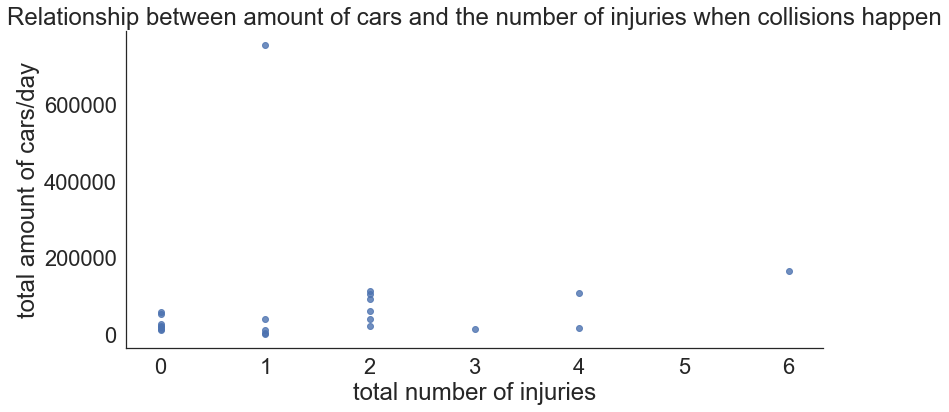

In [654]:
t = sns.lmplot(x = 'injured', y = 'total_count', data = temp, fit_reg = False, height = 6, aspect = 2).set(xlabel = 'total number of injuries', ylabel = 'total amount of cars/day', title = "Relationship between amount of cars and the number of injuries when collisions happen")


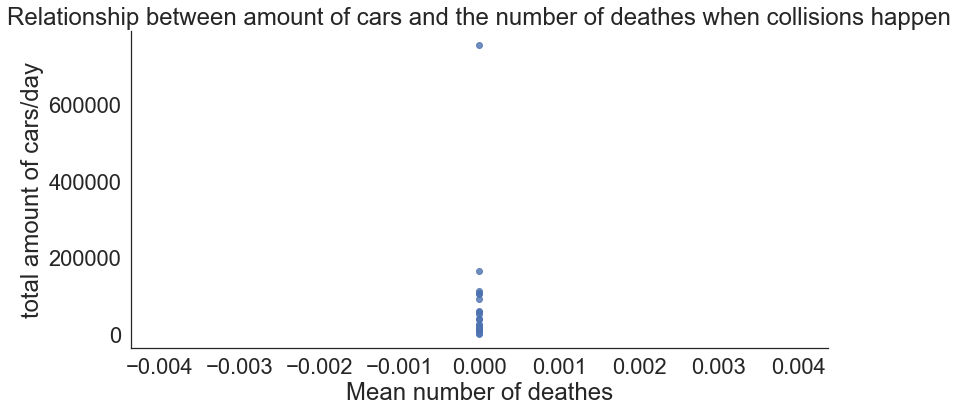

In [653]:
tsd = sns.lmplot(x = 'killed', y = 'total_count', data = temp, fit_reg = False, height = 6, aspect = 2).set(xlabel = 'Mean number of deathes', ylabel = 'total amount of cars/day', title = "Relationship between amount of cars and the number of deathes when collisions happen")


In [517]:
traffic

,id,street_name,limits,all_count,northbound_count,southbound_count,eastbound_count,westbound_count,total_count,file_no,count_date,DayOfWeek,holiday,is_holiday,is_weekend,street_name_clean
0,01AV018207,01 AV,A ST - ASH ST,,18010,NaN,NaN,NaN,18010,0182-07,2007-03-13,1,None,False,True,01
1,01AV015210,01 AV,A ST - ASH ST,,20060,NaN,NaN,NaN,20060,0152-10,2010-03-18,3,None,False,True,01
2,01AV018213,01 AV,A ST - ASH ST,,19597,NaN,NaN,NaN,19597,0182-13,2013-03-12,1,None,False,True,01
3,01AV088812,01 AV,ASH ST - BEECH ST,,2298,NaN,NaN,NaN,2298,0888-12,2012-12-11,1,None,False,True,01
4,01AV068711,01 AV,B ST - A ST,,15625,NaN,NaN,NaN,15625,0687-11,2011-09-01,3,None,False,True,01
5,01AV000714,01 AV,B ST - A ST,,13569,NaN,NaN,NaN,13569,0007-14,2014-02-11,1,None,False,True,01
6,01AV048412,01 AV,B ST - C ST,,13389,NaN,NaN,NaN,13389,0484-12,2012-05-31,3,None,False,True,01
7,01AV048115,01 AV,B ST - C ST,,13995,NaN,NaN,NaN,13995,0481-15,2015-06-17,2,None,False,True,01
8,01AV019406,01 AV,BEECH ST - CEDAR ST,,27450,NaN,NaN,NaN,27450,0194-06,2006-03-23,3,None,False,True,01
9,01AV017909,01 AV,BEECH ST - CEDAR ST,,22345,NaN,NaN,NaN,22345,0179-09,2009-03-31,1,None,False,True,01


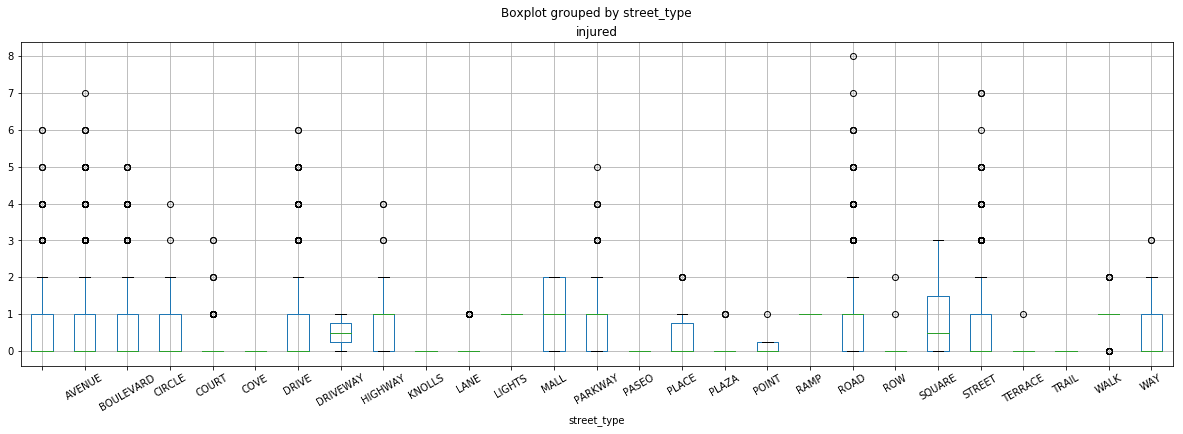

In [348]:
a = collisions[collisions['injured'] < 25]
a.boxplot('injured','street_type',rot = 30,figsize=(20,6))

### Boostrap
**Question: Statistical testing to see if there are more deaths involved in a collision happened on U.S. holiday than a normal day.**

In [350]:
collisions.groupby('holiday').sum()[['injured','killed']].sort_values(by = 'injured', ascending = False)

,injured,killed
holiday,,
New Year's Day,42,2
Washington's Birthday,42,1
Veterans Day,40,0
"Martin Luther King, Jr. Day",35,2
Independence Day,34,1
Veterans Day (Observed),33,1
Columbus Day,27,1
Labor Day,26,1
Thanksgiving,21,1


**Hypothesis testing 1**

Null Hypothesis: There is no difference in the probability of deaths occuring in a traffic collision on a U.S. holiday than a normal day.

Alternative Hypothesis: The probability of deaths occuring in a traffic collision on a U.S. holiday is higher than a normal day.

Level of Significance: 5%

Conclusion: Reject null hypothesis and conclude that the the probability of deaths occuring in a traffic collision on a U.S. holiday is higher than a normal day.

In [355]:
col_holi = collisions[ collisions['holiday'].notnull()]
num_holi = len(col_holi)
inj_expected = []
death_expected = []
for i in range(1000):
    pop = collisions.sample(num_holi)
    # proportion of collisions involved deaths
    death_sim = sum(pop['killed'] != 0)/ num_holi
    death_expected.append(death_sim)
death_observed = sum(col_holi['killed'] != 0)/ num_holi
death_expected = np.array(death_expected)
np.count_nonzero(death_expected >= death_observed)/1000

0.001

In [408]:
col_holi = collisions[collisions['killed']!= 0]
num_holi = sum(col_holi['is_holiday'])
death_expected = []
for i in range(1000):
    pop = col_holi.sample(num_holi)
    # proportion of collisions involved deaths
    death_sim = np.mean(pop['is_holiday'])
    death_expected.append(death_sim)
death_observed = np.mean(col_holi['is_holiday'])
death_expected = np.array(death_expected)
np.count_nonzero(death_expected >= death_observed)/1000

0.031

**Hypothesis testing 2**

Null Hypothesis: There is no difference in the number of deaths occuring in a traffic collision on a U.S. holiday than a normal day.

Alternative Hypothesis: The mean number of deaths occuring in a traffic collision on a U.S. holiday is higher than a normal day.

Level of Significance: 5%

Conclusion: Reject null hypothesis and conclude that the the mean number of deaths occuring in a traffic collision on a U.S. holiday is higher than a normal day.

In [413]:
col_holi = collisions[collisions['is_holiday']]
num_holi = len(col_holi)
inj_expected = []
death_expected = []
for i in range(1000):
    pop = collisions.sample(num_holi)
    # average deaths in collisions
    death_sim = np.mean(pop['killed'])
    death_expected.append(death_sim)
death_observed = np.mean(col_holi['killed'])
death_expected = np.array(death_expected)
np.count_nonzero(death_expected >= death_observed)/1000

0.001

## Data Visualization

### Barplot

**Question: How do the number of injuries and deaths related to the locations where the collisions happened?**

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

[Text(0, 0, 'Central'),
 Text(0, 0, 'Eastern'),
 Text(0, 0, 'Mid City'),
 Text(0, 0, 'Northern'),
 Text(0, 0, 'Northeastern'),
 Text(0, 0, 'Northwestern'),
 Text(0, 0, 'Southern'),
 Text(0, 0, 'Southeastern'),
 Text(0, 0, 'Western')]

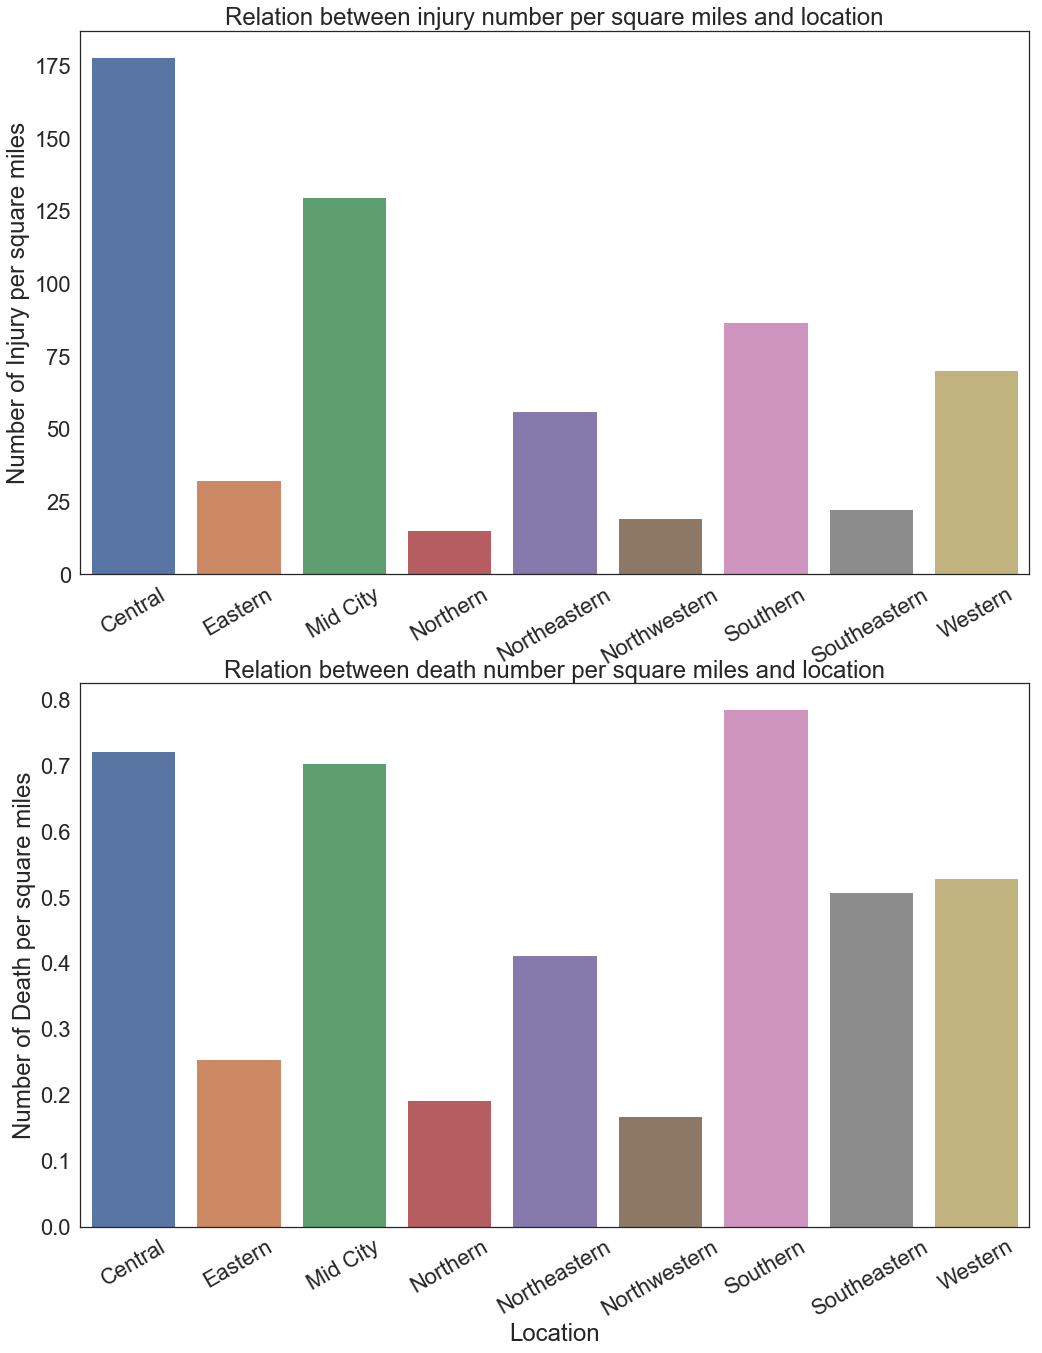

In [452]:
sns.set(style='white', font_scale=2) #Set up style
plt.rcParams['figure.figsize'] = (17, 22) #increase figure size

beat_inj = collisions[["police_beat",'injured']]
beat_inj['police_beat'] = beat_inj['police_beat']//100
beat_kil = collisions[["police_beat",'killed']]
beat_kil['police_beat'] = beat_kil['police_beat']//100

loc = {1: "Northern", 2: "Northeastern", 3: "Eastern", 4: "Southeastern", 5:"Central", 6: "Western", 7: "Southern", 8: "Mid City", 9:"Northwestern"}
for i in loc.keys():
    beat_inj['police_beat'] = beat_inj['police_beat'].replace(i,loc[i])
    beat_kil['police_beat'] = beat_kil['police_beat'].replace(i,loc[i])
    
size = {"Central":9.7, "Eastern": 47.1, "Mid City":12.8, "Northern":41.3, "Northeastern":103.8, "Northwestern":41.6, "Southern":31.5, "Southeastern":19.1, "Western":22.7 }
population = { "Central":103524, "Eastern":155892, "Mid City":173012, "Northern":225234, "Northeastern":234394, "Northwestern":70822, "Southern":107631, "Southeastern":175757, "Western":129709 }

injured_sum= beat_inj.groupby('police_beat').sum()
killed_sum= beat_kil.groupby('police_beat').sum()

for i in size.keys():
    injured_sum.loc[i] = injured_sum.loc[i]/size[i]
    killed_sum.loc[i] = killed_sum.loc[i]/size[i]

plt.subplot(2, 1, 1)
g = sns.barplot(x='police_beat', y='injured', data=injured_sum[1:].reset_index())
g.set(xlabel = '', ylabel='Number of Injury per square miles')
g.set_title("Relation between injury number per square miles and location")
labels = ["Central","Eastern","Mid City","Northern","Northeastern","Northwestern","Southern","Southeastern","Western"]
g.set_xticklabels(labels,rotation=30)

plt.subplot(2, 1, 2)
g = sns.barplot(x='police_beat', y='killed', data=killed_sum[1:].reset_index())
g.set(xlabel='Location', ylabel='Number of Death per square miles')
g.set_title("Relation between death number per square miles and location")
labels = ["Central","Eastern","Mid City","Northern","Northeastern","Northwestern","Southern","Southeastern","Western"]
g.set_xticklabels(labels,rotation=30)

In [406]:
table = sm.stats.Table.from_data(collisions[["is_holiday", "has_injuries"]])
table.test_nominal_association().pvalue
#able.fittedvalues

0.4669784862712283